In [25]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit


from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense
from keras.layers import LSTM, Dense, Input

In [13]:
#Plant states from index 0 - 5
plant_states = ["Saludable","Estresada","Deshidratada","Exceso de riego","Deficiencia nutrientes","Enferma"]

In [14]:
# Load the data
dataset = pandas.read_csv('arduinodata_with_plant_state4.csv', parse_dates=['timestamp'])
# Drop the 'id' column
dataset.drop(['id','deviceid'], axis=1, inplace=True)

#Set timestamp as index
dataset.set_index('timestamp', inplace=True)

print(dataset)

                            soilmoisture  temperature  airhumidity  \
timestamp                                                            
2024-05-01 16:48:28.804959            90         28.8           23   
2024-05-01 16:19:47.385657            90         29.0           24   
2024-05-01 15:51:07.664102            91         28.9           27   
2024-05-01 15:22:47.874908            88         28.0           30   
2024-05-01 14:53:34.880526            91         26.6           32   
...                                  ...          ...          ...   
2024-04-14 15:55:52.815886            91         23.4           35   
2024-04-14 15:27:01.788713            91         23.2           35   
2024-04-14 14:54:33.597601            88         28.2           28   
2024-04-14 13:51:05.035296            74         27.0           25   
2024-04-14 13:20:30.915587            76         25.2           29   

                            lightlevel  irrigationamount  state  
timestamp              

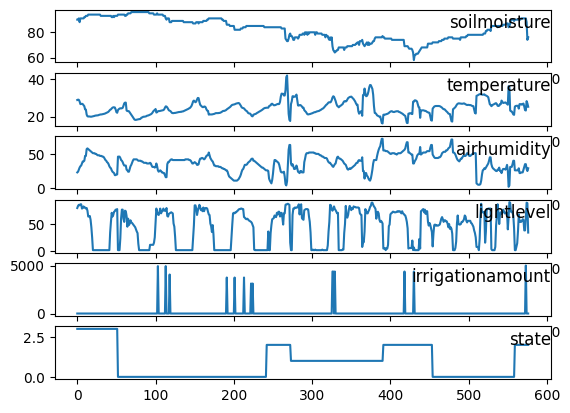

In [15]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
plt.show()

In [16]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pandas.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
     cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
     
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
     cols.append(df.shift(-i))
     
 if i == 0:
     names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
 else:
     names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
 # put it all together
 agg = pandas.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
     agg.dropna(inplace=True)
    
 return agg

In [33]:
# Ensure all data is float32 except the 'state' column
for col in dataset.columns:
    if col != 'state':
        dataset[col] = dataset[col].astype('float32')

# Separate the 'state' column
state_column = dataset['state']
# Drop the 'state' column from the dataset
numerical_data = dataset.drop('state', axis=1)

# Initialize and apply the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_numerical_data = scaler.fit_transform(numerical_data)

# Recombine the scaled numerical data with the 'state' column
scaled_numerical_data = pandas.DataFrame(scaled_numerical_data, columns=numerical_data.columns, index=dataset.index)
scaled_numerical_data['state'] = state_column

# Now transform dataset into a supervised learning format if needed
# For example, assuming series_to_supervised is a function you've defined or it's part of a package you are using:

#IMPORTANTE: EL SEGUNDO PARAMETRO ES EL QUE DETERMINA CUANTO ANTRAS MIRA PARA HACER LA PREDICCION
reframed = series_to_supervised(scaled_numerical_data, 48, 1)

# Drop columns you don't want to predict
# Update index to match dropped features after reframing if necessary
reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)

# Display the head of the reframed DataFrame to confirm
print(reframed.head())

                            var1(t-48)  var2(t-48)  var3(t-48)  var4(t-48)  \
timestamp                                                                    
2024-04-30 16:48:39.988560    0.842105    0.488281    0.300000    0.877778   
2024-04-30 16:18:10.850507    0.842105    0.496094    0.314286    0.922222   
2024-04-30 15:47:52.843476    0.868421    0.492188    0.357143    0.944444   
2024-04-30 15:19:31.290547    0.789474    0.457031    0.400000    0.933333   
2024-04-29 22:22:50.759753    0.868421    0.402344    0.428571    0.955556   

                            var5(t-48)  var6(t-48)  var6(t-47)  var1(t-46)  \
timestamp                                                                    
2024-04-30 16:48:39.988560         0.0         3.0         3.0    0.868421   
2024-04-30 16:18:10.850507         0.0         3.0         3.0    0.789474   
2024-04-30 15:47:52.843476         0.0         3.0         3.0    0.868421   
2024-04-30 15:19:31.290547         0.0         3.0         3.0 

In [19]:
#FORMA ANTIGUA

#Cross validation
# split into train and test sets
values = reframed.values

# 80% for training and 20% for testing
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(423, 1, 288) (423,) (106, 1, 288) (106,)


In [26]:
#FORMA NUEVA CON Stratified Shuffle Split

values = reframed.values
X = values[:, :-1]
y = values[:, -1].astype(int)  # Ensure labels are integer

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    train_X, test_X = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [27]:
# Convert labels to integer encodings
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)

# Convert labels to one-hot encodings
train_y_categorical = to_categorical(train_y_encoded)
test_y_categorical = to_categorical(test_y_encoded)

In [37]:
print("Train X shape:", train_X.shape)
print("Train Y shape:", train_y_categorical.shape)
print("Test X shape:", test_X.shape)
print("Test Y shape:", test_y_categorical.shape)



Train X shape: (423, 1, 288)
Train Y shape: (423, 4)
Test X shape: (106, 1, 288)
Test Y shape: (106, 4)


Epoch 1/50
6/6 - 1s - 139ms/step - accuracy: 0.3735 - loss: 1.2460 - val_accuracy: 0.5566 - val_loss: 1.0348
Epoch 2/50
6/6 - 0s - 6ms/step - accuracy: 0.5579 - loss: 0.9571 - val_accuracy: 0.5566 - val_loss: 0.8757
Epoch 3/50
6/6 - 0s - 5ms/step - accuracy: 0.5485 - loss: 0.8219 - val_accuracy: 0.5849 - val_loss: 0.7569
Epoch 4/50
6/6 - 0s - 7ms/step - accuracy: 0.6667 - loss: 0.7080 - val_accuracy: 0.7453 - val_loss: 0.6612
Epoch 5/50
6/6 - 0s - 6ms/step - accuracy: 0.7920 - loss: 0.6123 - val_accuracy: 0.8019 - val_loss: 0.5831
Epoch 6/50
6/6 - 0s - 9ms/step - accuracy: 0.8629 - loss: 0.5304 - val_accuracy: 0.8491 - val_loss: 0.5057
Epoch 7/50
6/6 - 0s - 6ms/step - accuracy: 0.8865 - loss: 0.4567 - val_accuracy: 0.8679 - val_loss: 0.4439
Epoch 8/50
6/6 - 0s - 6ms/step - accuracy: 0.9102 - loss: 0.3953 - val_accuracy: 0.8868 - val_loss: 0.3907
Epoch 9/50
6/6 - 0s - 6ms/step - accuracy: 0.9338 - loss: 0.3462 - val_accuracy: 0.9434 - val_loss: 0.3487
Epoch 10/50
6/6 - 0s - 5ms/step - a

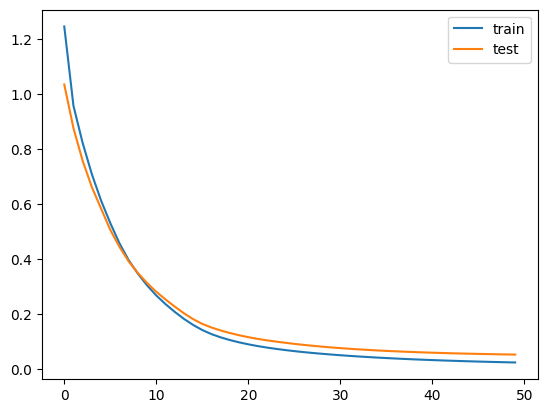

In [29]:
# design network
model = Sequential()
model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50))
model.add(Dense(train_y_categorical.shape[1], activation='softmax'))  # Output layer for categorical prediction
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y_categorical, epochs=50, batch_size=72, validation_data=(test_X, test_y_categorical), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
print("Shape of test_X:", test_X.shape)
print("Data type of test_X:", test_X.dtype)
model.summary()

Shape of test_X: (106, 1, 288)
Data type of test_X: float64


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        67,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,014 (796.93 KB)

 Trainable params: 68,004 (265.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 136,010 (531.29 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Accuracy: 0.9905660377358491
Confusion Matrix:
 [[59  0  0  0]
 [ 0 24  0  0]
 [ 1  0 21  0]
 [ 0  0  0  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        59
           1       1.00      1.00      1.00        24
           2       1.00      0.95      0.98        22
           3       1.00      1.00      1.00         1

    accuracy                           0.99       106
   macro avg       1.00      0.99      0.99       106
weighted avg       0.99      0.99      0.99       106



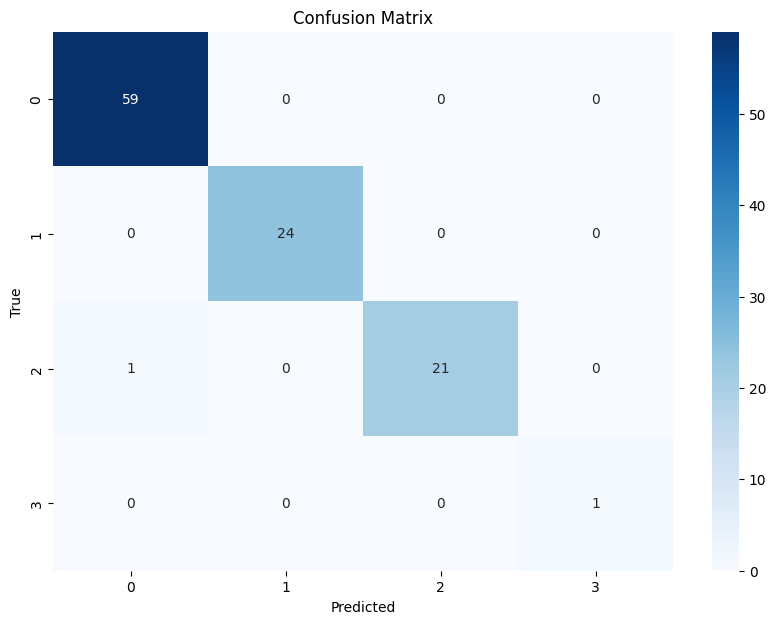

In [31]:
# Step 1: Make predictions
yhat_probs = model.predict(test_X)
yhat_classes = np.argmax(yhat_probs, axis=1)

# Assuming test_y_categorical is one-hot encoded, convert it back to class labels for evaluation
test_y_labels = np.argmax(test_y_categorical, axis=1)

# Step 2: Evaluate the model
accuracy = accuracy_score(test_y_labels, yhat_classes)
print('Accuracy:', accuracy)

# Print the confusion matrix
cm = confusion_matrix(test_y_labels, yhat_classes)
print('Confusion Matrix:\n', cm)

# Print a classification report
report = classification_report(test_y_labels, yhat_classes)
print('Classification Report:\n', report)

# Step 3: Optional visualization - Plot confusion matrix


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()